In [1]:
import visualID_Eng as vID
vID.init()

**Start at:** Friday 23 September 2022, 09:46:38  
**Hostname:** localhost.localdomain (Linux)

<p style="text-align: center"><img width="800px" src="./svg/logoPytChem.svg" style="margin-left:auto; margin-right:auto"/></p>

# Prediction by an artificial neural network of the solubility of CO<sub>2</sub> in ionic liquids

<div class="rq">
<b>Reference</b>: 
Z. Song, H. Shi, X. Zhang & T. Zhou (**2020**), Prediction of CO<sub>2</sub> solubility in ionic liquids using machine learning methods, [<i>Chem. Eng. Sci.</i> <b>223</b>: 115752](https://www.doi.org/10.1016/j.ces.2020.115752) 
<br>
<p style="text-align: center"><img width="650px" src="./CO2-images/AbstractANNCO2-SongEtal.png" style="margin-left:auto; margin-right:auto" id="img_AbstractSong"></p>
<br>
The main results are graphically reported below.
<br>
<p style="text-align: center"><img width="900px" src="./CO2-images/ANNCO2-SongEtal-Results.png" style="margin-left:auto; margin-right:auto" id="img_ResultsSong"></p>
<br>
Yet, it seems sthat no standardization process of the data has been applied. 
    
<span style="color:red">Moreover, a spurious separation of the data between training and test sets has been applied: "<i>Instead of performing random selection, we employ a hybrid artificial-random strategy to decompose the dataset. Specifically, the data points consisting of the least frequently used groups are equally divided into five folders"</i></span> 
<br><br>
<b>It raises doubts about the stability of the algorithm developped in this paper (*unless the authors forgot to mention that data were standardized*).</b>
<br>
</div>

<div class="warn">
<span style="font-weight:bold">The goal of this exercise is to apply the <i>K</i>-fold cross-validation the ANN part of this article, <i>i.e.</i> without standardized data. </span>
</div>

In [2]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
    
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import tensorflow as tf
from tensorflow import keras
import os,sys
from IPython.display import display
    
import numpy as np
import pandas as pd
from IPython.display import display

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   OFF = '\033[0m'

<a id="data-read"></a>
## **1.** Database reading

In [3]:
dataCO2f='CO2-data'+'/'+'dataCO2.csv'
dataCO2=pd.read_csv(dataCO2f,sep=";",header=0)
display(dataCO2)
# describe() generates descriptive statistics
display(dataCO2.describe().style.format("{0:.2f}"))

,IL,cation,anion,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,[BMIM][BF4],[BMIM],[BF4],0.610,363.15,246.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[BMIM][BF4],[BMIM],[BF4],0.500,383.15,235.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[BMIM][BF4],[BMIM],[BF4],0.610,353.15,223.30,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[BMIM][BF4],[BMIM],[BF4],0.500,373.15,198.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[BMIM][BF4],[BMIM],[BF4],0.610,343.15,188.50,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10111,[HMIM][Tf2N],[HMIM],[Tf2N],0.592,298.15,35.86,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10112,[HMIM][Tf2N],[HMIM],[Tf2N],0.239,343.15,27.54,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10113,[HMIM][Tf2N],[HMIM],[Tf2N],0.396,298.15,20.15,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10114,[HMIM][Tf2N],[HMIM],[Tf2N],0.140,343.15,17.93,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0


,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00
mean,0.33,325.27,54.21,1.18,4.72,0.02,0.02,0.04,0.04,0.01,0.06,0.00,0.00,0.01,0.77,0.01,0.00,0.01,0.09,0.00,0.00,0.01,0.00,0.02,0.05,0.00,0.11,0.02,0.02,0.02,0.11,0.02,0.01,0.07,0.00,0.01,0.43,0.00,0.01,0.01,0.00,0.02,0.01,0.01,0.02,0.05,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.00
std,0.24,25.24,76.66,0.96,5.48,0.25,0.16,0.20,0.39,0.10,0.28,0.06,0.06,0.10,0.42,0.08,0.07,0.11,0.29,0.06,0.07,0.09,0.06,0.16,0.23,0.06,0.31,0.12,0.15,0.12,0.31,0.14,0.08,0.26,0.04,0.11,0.49,0.03,0.11,0.11,0.05,0.13,0.11,0.10,0.15,0.23,0.09,0.08,0.06,0.10,0.03,0.07,0.04,0.05
min,0.00,243.20,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.14,308.15,10.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.30,323.15,26.80,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.51,342.59,64.76,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,0.95,453.15,499.90,7.00,28.00,3.00,2.00,1.00,5.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## 2. Assessment of the stability of the original ML algorithm of Song *et al*. by *K*-fold cross validation 


In [4]:
#######################################################################################
# separation of the data set into two subsets: (1) training of the ANN & (2) test of the ANN
# library used: pandas
xdata = dataCO2.drop(['IL','cation','anion','x_CO2'],axis=1)
ydata = dataCO2['x_CO2']

#######################################################################################
# ANN: 1 input layer (53 neurons) / 2 hidden layers (20 and 7 neurons) / 1 output layer (1 neuron) 
# library used: keras

def defANN(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(keras.layers.Dense(7, activation=acthL, name='hLayer'))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

acthL='tanh'

Fold 0
Epoch 1/200


2022-09-23 09:46:43.859959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


324/324 [==============================] - 1s 2ms/step - loss: 0.1566 - mae: 0.2790 - mse: 0.1566 - val_loss: 0.0360 - val_mae: 0.1548 - val_mse: 0.0360
Epoch 2/200
324/324 [==============================] - 1s 2ms/step - loss: 0.0293 - mae: 0.1363 - mse: 0.0293 - val_loss: 0.0316 - val_mae: 0.1373 - val_mse: 0.0316
Epoch 3/200
324/324 [==============================] - 1s 2ms/step - loss: 0.0236 - mae: 0.1245 - mse: 0.0236 - val_loss: 0.0224 - val_mae: 0.1205 - val_mse: 0.0224
Epoch 4/200
324/324 [==============================] - 1s 2ms/step - loss: 0.0220 - mae: 0.1204 - mse: 0.0220 - val_loss: 0.0284 - val_mae: 0.1321 - val_mse: 0.0284
Epoch 5/200
324/324 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.1158 - mse: 0.0202 - val_loss: 0.0186 - val_mae: 0.1101 - val_mse: 0.0186
Epoch 6/200
324/324 [==============================] - 1s 2ms/step - loss: 0.0191 - mae: 0.1122 - mse: 0.0191 - val_loss: 0.0187 - val_mae: 0.1112 - val_mse: 0.0187
Epoch 7/200
324/324 [=

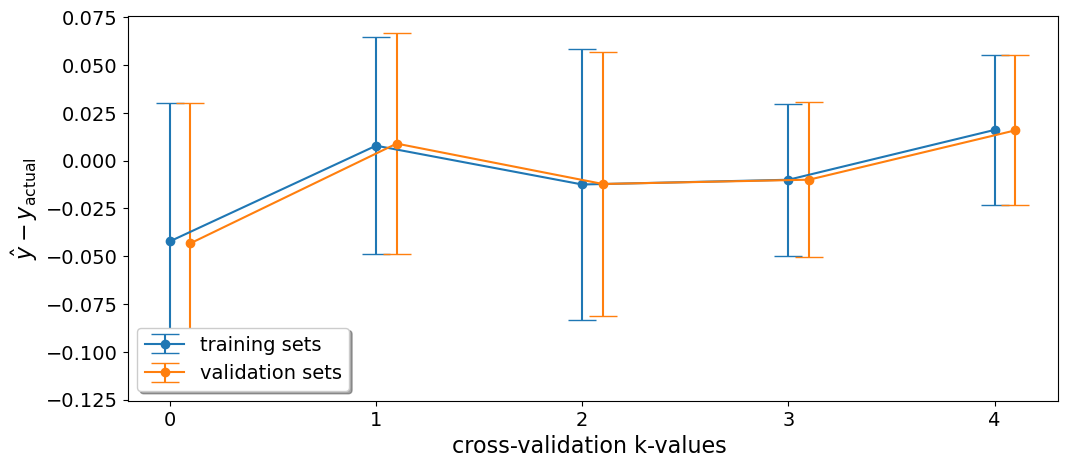

In [5]:
#######################################################################################
# optimization of the ANN
# library used: keras and scikit learn for the KFold cross-validator
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
from sklearn.model_selection import KFold
from sklearn import preprocessing

VERBOSE = 1
EPOCHS = 200
BATCH_SIZE = 25
N_SPLIT = 5

vID.chrono_start()

# variables created to save at each iteration of the KFold process: the man error, the standard deviation, MAE, R2
meantT=list()
stdtT=list()
MAEtT=list()
R2tT=list()
meanvT=list()
stdvT=list()
MAEvT=list()
R2vT=list()

kfold = KFold(n_splits=N_SPLIT,shuffle=True,random_state=42) # k-fold is here!
#print(list(kfold.split(x_train,y_train)))

j = 0 # Variable for keeping count of split we are executing
# The KFold cv provides train/test indices to split data in train/test sets
for train_idx, val_idx in list(kfold.split(xdata,ydata)):

    x_train_cv = xdata.iloc[train_idx]
    x_valid_cv = xdata.iloc[val_idx]
    y_train_cv = ydata.iloc[train_idx]
    y_valid_cv = ydata.iloc[val_idx]
#    display(x_train_cv,x_valid_cv)
# This part has been commented with respect to the original script
    # scaler = preprocessing.StandardScaler()
    # scaler.fit(x_train_cv.values)
    # xt_scaled = scaler.transform(x_train_cv.values) #returns a numpy array
    # xv_scaled = scaler.transform(x_valid_cv.values) #returns a numpy array
    # x_train_cv = pd.DataFrame(xt_scaled, index=x_train_cv.index, columns=x_train_cv.columns)
    # x_valid_cv = pd.DataFrame(xv_scaled, index=x_valid_cv.index, columns=x_valid_cv.columns)
    # del xt_scaled, xv_scaled
##############
#    display(x_train_cv.describe().style.format("{0:.2f}").set_caption("Training set after normalization (with scikit-learn):"))
#    display(x_valid_cv.describe().style.format("{0:.2f}").set_caption("Validation set after normalization (with scikit-learn):"))
    print(f"{color.BOLD}{color.RED}Fold {j}{color.OFF}")
    j+=1
    ANNmodel=defANN( (53,), acthL )
    ANNhistory = ANNmodel.fit(x_train_cv,
                        y_train_cv,
                        epochs          = EPOCHS,
                        batch_size      = BATCH_SIZE,
                        verbose         = VERBOSE,
                        validation_data = (x_valid_cv, y_valid_cv),
                        callbacks=[es])
    ytrain_hat=ANNmodel.predict(x_train_cv)
    yvalid_hat=ANNmodel.predict(x_valid_cv)
    diffyt = ytrain_hat.ravel() - y_train_cv.ravel()
    diffyv = yvalid_hat.ravel() - y_valid_cv.ravel()

    print()
    print("xCO2(predicted) - xCO2(actual)")
    print(
          "Train.","mean: ", np.mean(diffyt),
          "   std: ", np.std(diffyt),
          "   MAE: ", np.average(abs(diffyt)),
          "    R2: ", np.corrcoef(y_train_cv.ravel(),ytrain_hat.ravel())[0,1]
         )
    print(
          "Test.","mean: ", np.mean(diffyv),
          "   std: ", np.std(diffyv),
          "   MAE: ", np.average(abs(diffyv)),
          "    R2: ", np.corrcoef(y_valid_cv.ravel(),yvalid_hat.ravel())[0,1]
         )
    meantT.append(np.mean(diffyt))
    meanvT.append(np.mean(diffyv))
    stdtT.append(np.std(diffyt))
    stdvT.append(np.std(diffyv))
    MAEtT.append(np.average(abs(diffyt)))
    MAEvT.append(np.average(abs(diffyv)))
    R2tT.append(np.corrcoef(y_train_cv.ravel(),ytrain_hat.ravel())[0,1])
    R2vT.append(np.corrcoef(y_valid_cv.ravel(),yvalid_hat.ravel())[0,1])
    
vID.chrono_show()

#######################################################################################
# accuracy of the ANN?
# library used: numpy
print(f"{color.BOLD}average MAE of the training set:{color.OFF}   {np.mean(MAEtT):.2f} +/- {np.std(MAEtT):.2f}")
print(f"{color.BOLD}average MAE of the validation set:{color.OFF} {np.mean(MAEvT):.2f} +/- {np.std(MAEvT):.2f}")

figCV, axCV = plt.subplots(1, 1)
figCV.set_size_inches(12,5)
axCV.errorbar(x=np.arange(len(meantT)), y=meantT, yerr=MAEtT, label='training sets', fmt='o-', capsize=10)
axCV.errorbar(x=np.arange(len(meanvT))+0.1, y=meanvT, yerr=MAEvT, label='validation sets', fmt='o-', capsize=10)
axCV.legend(loc='lower left', shadow=True, fontsize='14')
axCV.set_xlabel('cross-validation k-values ',fontdict={'fontsize':16})
axCV.set_ylabel('$\hat{y}-y_{\mathrm{actual}}$',fontdict={'fontsize':16})
axCV.tick_params(labelsize = 14)
plt.savefig('./CO2-images/KFold-cv-AppliedToSong_etal.png',dpi=300,bbox_inches='tight')
plt.show()


<div class="warn">
You have probably found results similar to those reported in the following error plot:
<p style="text-align: center"><img width="650px" src="./CO2-images/KFold-cv-AppliedToSong_etalK.png" style="margin-left:auto; margin-right:auto" id="img_ResultsSong"></p>
    <b>This error plot shows a bad performance of the original ML algorithm of Song <i>et al</i>. (<i>i.e.</i> without standardization of the data), with a strong variation of error bars.</b>
    
Either the authors did actually apply a standardization preprocessing and they forgot to mention it in the article, or they ran several optimization algorithms of the ANN until they found a seemingly performant one.
</div>

In [6]:
vID.end()

**End at:** Thursday 30 June 2022, 12:35:06  
**Duration:** 00:05:04 872ms

<p style="text-align: center"><img width="800px" src="./svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>